In [2]:
pip install pandas numpy tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import random
from datetime import timedelta, datetime

# Set random seed for reproducibility
np.random.seed(42)

# Generate a sequence of dates (e.g., over one year)
def generate_dates(start_date, days):
    return [start_date + timedelta(days=x) for x in range(days)]

# Parameters
num_days = 365
traffic_volume_range = (100, 2000)  # Simulate number of cars per day
weather_conditions = ['clear', 'rain', 'fog', 'snow']
road_types = ['highway', 'urban road', 'rural road']

# Create base date
start_date = datetime(2023, 1, 1)
dates = generate_dates(start_date, num_days)

# Generate data
data = {
    'date': dates,
    'traffic_volume': np.random.randint(traffic_volume_range[0], traffic_volume_range[1], num_days),
    'weather_condition': np.random.choice(weather_conditions, num_days),
    'road_type': np.random.choice(road_types, num_days)
}

# Simulate accident occurrence based on certain conditions
# We'll make accidents more likely in bad weather and high traffic
def simulate_accident(row):
    if row['weather_condition'] in ['rain', 'fog', 'snow'] and row['traffic_volume'] > 1500:
        return 1 if random.random() < 0.3 else 0  # 30% chance of accident
    elif row['traffic_volume'] > 1800:
        return 1 if random.random() < 0.2 else 0  # 20% chance of accident
    else:
        return 1 if random.random() < 0.05 else 0  # 5% chance otherwise

# Create DataFrame
df = pd.DataFrame(data)

# Apply function to create accident occurrence
df['accident_occurred'] = df.apply(simulate_accident, axis=1)

# Show a preview of the dataset
print(df.head())

# Save dataset to CSV
df.to_csv('synthetic_traffic_accident_data.csv', index=False)

        date  traffic_volume weather_condition   road_type  accident_occurred
0 2023-01-01            1226               fog  urban road                  0
1 2023-01-02            1559              snow  rural road                  0
2 2023-01-03             960              snow     highway                  0
3 2023-01-04            1394               fog  rural road                  0
4 2023-01-05            1230              snow  urban road                  0


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('synthetic_traffic_accident_data.csv')

# Preview the data
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Convert categorical features into numerical form (Label Encoding)
label_encoder = LabelEncoder()
df['weather_condition'] = label_encoder.fit_transform(df['weather_condition'])
df['road_type'] = label_encoder.fit_transform(df['road_type'])

# Normalize features (LSTM requires normalized data)
scaler = MinMaxScaler()
df[['traffic_volume', 'weather_condition', 'road_type']] = scaler.fit_transform(df[['traffic_volume', 'weather_condition', 'road_type']])

# Target column ('accident_occurred') should remain binary

         date  traffic_volume weather_condition   road_type  accident_occurred
0  2023-01-01            1226               fog  urban road                  0
1  2023-01-02            1559              snow  rural road                  0
2  2023-01-03             960              snow     highway                  0
3  2023-01-04            1394               fog  rural road                  0
4  2023-01-05            1230              snow  urban road                  0
date                 0
traffic_volume       0
weather_condition    0
road_type            0
accident_occurred    0
dtype: int64


In [6]:
# Create sequences and labels
def create_sequences(data, target, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Define features and target
features = df[['traffic_volume', 'weather_condition', 'road_type']].values
target = df['accident_occurred'].values

# Create sequences with a 7-day time window (adjust if needed)
time_steps = 7
X, y = create_sequences(features, target, time_steps)

# Split into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

Training data shape:  (286, 7, 3)
Testing data shape:  (72, 7, 3)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 50)               │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.7830 - loss: 0.6564 - val_accuracy: 0.9028 - val_loss: 0.5349
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8766 - loss: 0.5079 - val_accuracy: 0.9028 - val_loss: 0.3351
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8913 - loss: 0.3606 - val_accuracy: 0.9028 - val_loss: 0.3093
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8713 - loss: 0.4032 - val_accuracy: 0.9028 - val_loss: 0.3042
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8804 - loss: 0.3650 - val_accuracy: 0.9028 - val_loss: 0.3110
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8901 - loss: 0.3489 - val_accuracy: 0.9028 - val_loss: 0.3063
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8715 - loss: 0.3820 - val_accuracy: 0.9028 - val_loss: 0.3045
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8997 - loss: 0.3275 - val_accuracy: 0.9028 - val_loss: 0.3032

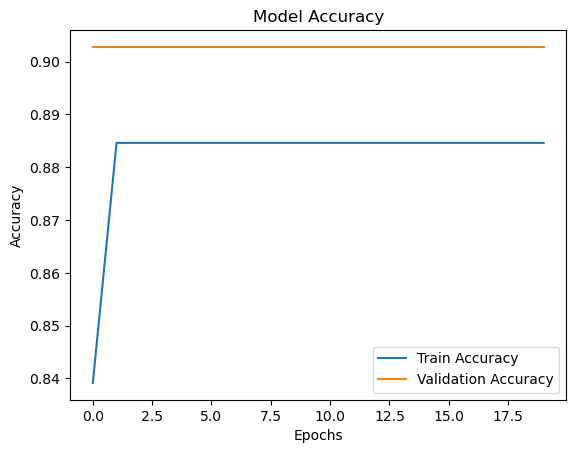

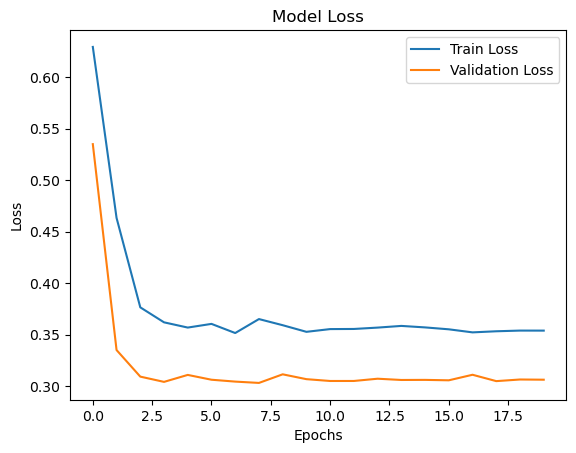

In [8]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9006 - loss: 0.3125 
Test Accuracy: 90.28%


In [10]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to binary (accident or no accident)
y_pred_binary = (y_pred > 0.5).astype(int)

# Example: Comparing the predicted and actual values for the first 10 test cases
print(f"Predicted: {y_pred_binary[:10].flatten()}")
print(f"Actual: {y_test[:10]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Predicted: [0 0 0 0 0 0 0 0 0 0]
Actual: [0 0 0 0 1 0 0 0 0 0]


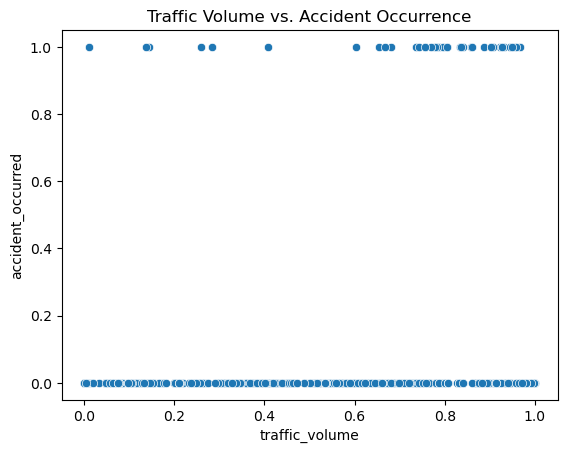

In [11]:
import seaborn as sns

# Plot the relationship between traffic volume and accidents
sns.scatterplot(x=df['traffic_volume'], y=df['accident_occurred'])
plt.title('Traffic Volume vs. Accident Occurrence')
plt.show()